### Exercise 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

---
### Large Dataset Generation
Generate a large set `X, y` of input-output examples as ground-truth population for two purposes: 

1. **Risk and variance computation:** Use `X, y` to compute the true risk $R(f)$ of a classifier $f$ and the variance $\mathbb{V}[x]$, where $x$ is the binary random variable with 

$$
x = \begin{cases}
1 &:& f(x) \neq y\\
0 &:& \text{otherwise}
\end{cases}
$$

2. **Sampling:** Sample training and test sets from `X, y`.

In [8]:
# size of population
N = int(1e5)

centers = ((1, 1), (-1, 1), (-1, -1), (1, -1))
X, y = make_blobs(N, centers=centers, cluster_std=.5)
y[y==2], y[y==3] = 0, 1

---
### Auxiliary Functions

In [10]:
def sample(n, rs=None):
    '''Samples a training set of size n from the population X, y.

    Parameter:
      n   size of training set
      rs  random state 
    '''
    X_tr,_,y_tr,_ = train_test_split(X, y, train_size=n, random_state=rs)
    return X_tr, y_tr

def test_n(f, n, t=0.05, n_runs=100, verbose=True):
    ''' 
    In the first part, the function proceeds as follows:

    1. samples a training set of size n
    2. fits classifier f on training data
    3. computes empirical risk Rn(f)
    4. computes true risk R(f) 
    5. computes variance V[x]
    6. computes Chebyshev's bound
    7. prints results if verbose is True

    Note that the function f obtained in step 2 by ERM is arbitrary. We could randomly select a function from the underlying hypothesis class to conduct the experiment.

    In the second part, the function repeats the following experiment n_runs times:

    1. sample a test set of size n from X, y
    2. compute the empirical risk Rn(f) on the test set
    3. compute the deviation |Rn(f) - R(f)|

    Count the number of deviations for which |Rn(f) - R(f)| >= t and compute the fraction over all n_runs trials to approximate P(|Rn(f) - R(f)| >= t). Print the estimated probability and Chebyshev's bound if verbose is True. 

    Return the estimated probability and bound.


    Parameters:
    f        classifier
    n        size of training set
    t        error tolerance in |Rn(f) - R(f)| >= t
    n_runs   number of trials
    verbose  print results if True 

    Return:
    prob    estimated probability P(|Rn(f) - R(f)| >= t)
    bound   estimated Chebyshev bound
    '''

    # fixed training set (use random_state)
    X_train, y_train = sample(n, rs=13)
    # fit classifier f on training set
    f.fit(X_train, y_train)
    # empirical risk of f
    Rn = 1. - f.score(X_train, y_train)

    # true risk R(f) and variance V[xi]
    errors = f.predict(X) != y
    R = np.mean(errors)
    V = np.var(errors)

    # Chebyshev's bound
    bound = V/(n*t*t)

    # print results
    if verbose: 
        print(f'n       = {n:d}')
        print(f'Rn(f)   = {Rn:.2f}')
        print(f'R(f)    = {R:.2f}')
        print(f'Var(xi) = {V:.2f}')
        print(f'Bound   = {bound:.2f}')
        print()
        
    # estimate P(|Rn(f) - R(f)| >= t)
    n_deviations = 0
    for _ in range(n_runs):
        X_test, y_test = sample(n)
        Rn = 1. - f.score(X_test, y_test)
        if np.abs(Rn -  R) >= t:
            n_deviations += 1
    prob = n_deviations / n_runs
    
    if verbose:
        print(f'# deviations: {n_deviations}')
        print(f'P(|Rn(f)-R(f)|>=t) = {prob:.2f}', f'<=? {bound:.2f}')

    return prob, bound

    
def test(f, t=0.05, n_runs=100):
    '''Call function test_n for varying sizes n.

    Return the sizes, probabilities, and bounds. The sizes n are hard coded. For each n, the estimated probability P(|Rn(f) - R(f)| >= t) and Chebyshev bound are returned by the function test_n. 
    
    Parameter:
    f       classifier
    t       error tolerance
    n_runs  number of trials (for test_n)

    Return:
    size    array of sizes n
    p       array of estimated probabilities P(|Rn(f) - R(f)| >= t) 
    b       array of estimated Chebyshev bounds
    '''
    
    size = [12, 20, 40, 100, 200, 400, 800, 1000]
    p = np.zeros(len(size))
    b = np.zeros(len(size))
    for i, n in enumerate(size):
        p[i], b[i] = test_n(f, n, t, n_runs, False)
    return size, p, b

def plot(size, p, b):
    '''Plots the probability of deviations and the Chebyshev bounds as a function of sample size.
    
    Parameter:
    size    array of sizes n
    p       array of estimated probabilities P(|Rn(f) - R(f)| >= t) 
    b       array of estimated Chebyshev bounds
    '''
    
    plt.plot(size, p, label='P(|Rn(f)-R(f)|>t)')
    plt.plot(size, b, label='bound')
    plt.ylim((0, 2))
    plt.legend()
    plt.show()

---
### Logistic Regression

n       = 40
Rn(f)   = 0.40
R(f)    = 0.62
Var(xi) = 0.24
Bound   = 2.36

# deviations: 44
P(|Rn(f)-R(f)|>=t) = 0.44 <=? 2.36


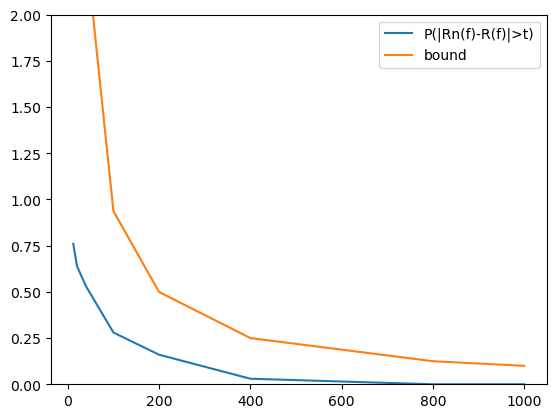

In [11]:
f = LogisticRegression(penalty=None)
test_n(f, n=40)
size, p, b = test(f)
plot(size, p, b)

---
### MLP

n       = 40
Rn(f)   = 0.00
R(f)    = 0.11
Var(xi) = 0.10
Bound   = 0.95

# deviations: 33
P(|Rn(f)-R(f)|>=t) = 0.33 <=? 0.95


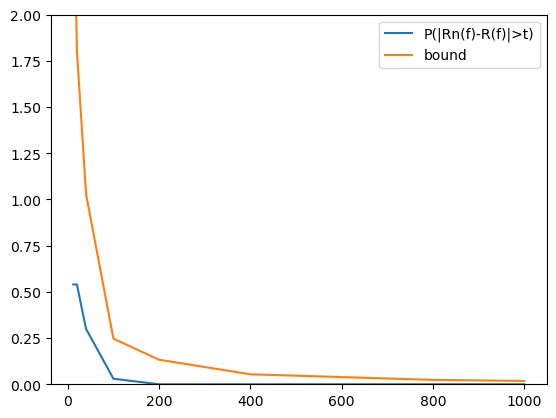

In [12]:
f = MLPClassifier(hidden_layer_sizes=(50, 250, 50), max_iter=1000)
test_n(f, n=40)
size, p, b = test(f)
plot(size, p, b)